# Prep

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

Config finished!


In [2]:
df = pd.read_csv('./data/Exalted Orb.csv')
df.head()

,Date,Value,League,Confidence
0,2016-09-08,64.00417,Essence,0
1,2016-09-09,64.51451,Essence,0
2,2016-09-10,65.00280,Essence,0
3,2016-09-11,65.05764,Essence,0
4,2016-09-12,65.98811,Essence,0


`Note:` Confidence encoding: {'High': 0, 'Low': 1, 'Medium': 2}


# Train Val split
We do validation one the last league and use others to train

In [3]:
# is_last_league = df['League'] == Constants.LEAGUES[-1]
# df_train = df[~is_last_league]
# df_val = df[is_last_league]
# df_train.shape, df_val.shape

In [4]:
def train_val_split(df, selected_features):
    is_last_league = df['League'] == Constants.LEAGUES[-1]

    df_selected = df[selected_features]
    df_train = df_selected[~is_last_league]
    df_val = df_selected[is_last_league]
    return df_train, df_val
def print_train_val_stats(train,val):
    print('shapes: ', train.shape, val.shape)
    display(train.head())
    display(val.head())

def getXY(df, target = 'Value'):
    df_features = df.drop(target, axis = 1)
    df_target = df.loc[:, [target]]
    return df_features, df_target

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X_val, y_val):
    pred = model.predict(X_val)
    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)


# Time index regression

In [5]:
df1 = df.copy()
df1['Time'] = np.arange(len(df1.index))

train1, val1 = train_val_split(df1, ['Value', 'Time'])
print_train_val_stats(train1,val1)

shapes:  (1719, 2) (88, 2)


,Value,Time
0,64.00417,0
1,64.51451,1
2,65.00280,2
3,65.05764,3
4,65.98811,4


,Value,Time
1719,50.00000,1719
1720,62.00000,1720
1721,72.57994,1721
1722,77.00000,1722
1723,75.91450,1723


In [19]:
from sklearn.linear_model import LinearRegression


model1 = LinearRegression()
model1.fit(*getXY(train1))

evaluate(model1, *getXY(train1))
evaluate(model1, *getXY(val1))

Result - MSE:  1297.9654133767842  - MAPE:  0.2543896624871606
Result - MSE:  1069.7061216287177  - MAPE:  0.17364739924971567


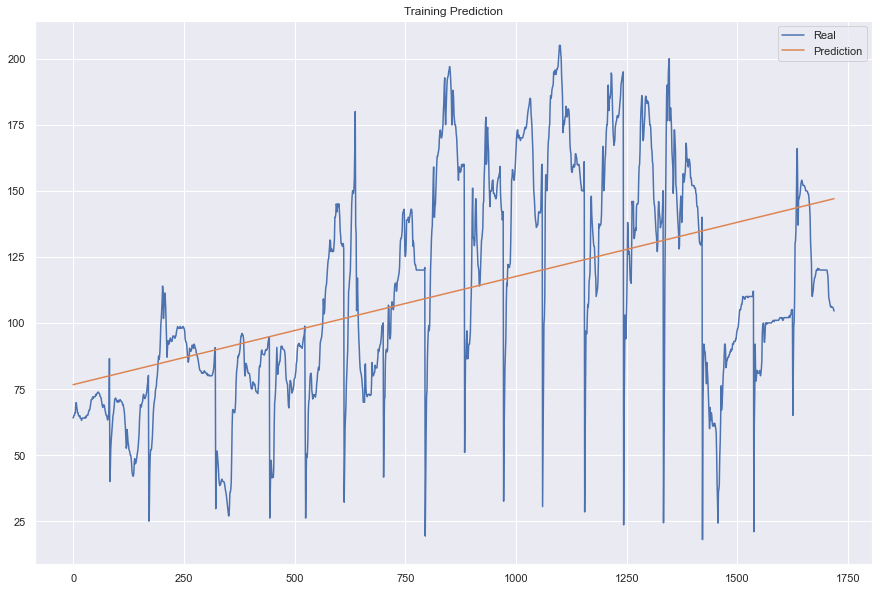

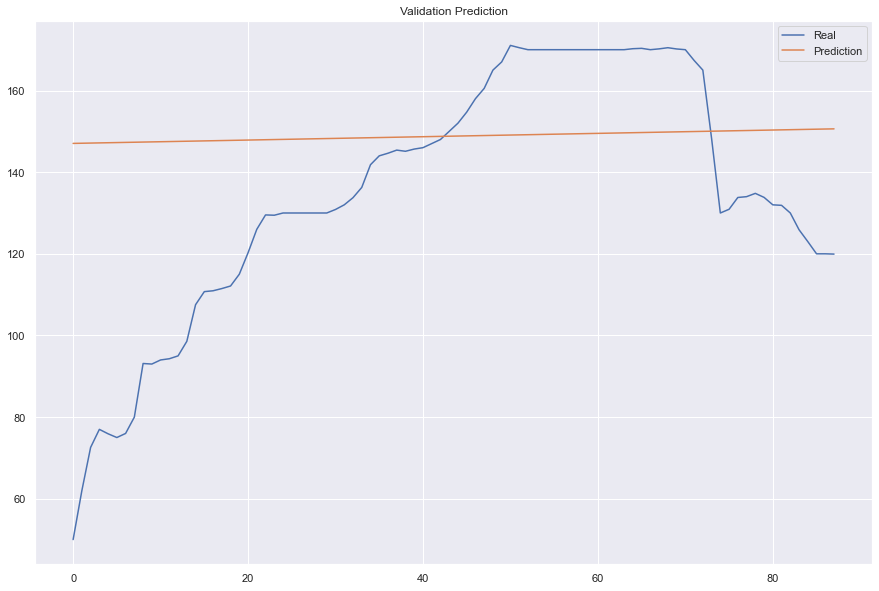

In [18]:
def plot_prediction(model, df, name):
    x, y = getXY(df)
    pred = model.predict(x)

    reseted_y = y.reset_index(drop=True)
    plt.plot(reseted_y, label = 'Real')
    plt.plot(pred, label = 'Prediction')
    plt.legend()
    plt.title(name)
    plt.show()

plot_prediction(model1, train1, 'Training Prediction')
plot_prediction(model1, val1, 'Validation Prediction')


# Linear Regression with Lag 1

`Note`: we established that lag 1 and 2 have highest autocorrelation

In [20]:
df2 = df.copy()
df2['Lag1'] = df2['Value'].shift(1)
df2.dropna(inplace=True) # since shifting creates Nan

train2, val2 = train_val_split(df2, ['Value', 'Lag1'])
print_train_val_stats(train2,val2)

shapes:  (1718, 2) (88, 2)


,Value,Lag1
1,64.51451,64.00417
2,65.00280,64.51451
3,65.05764,65.00280
4,65.98811,65.05764
5,66.01724,65.98811


,Value,Lag1
1719,50.00000,104.50518
1720,62.00000,50.00000
1721,72.57994,62.00000
1722,77.00000,72.57994
1723,75.91450,77.00000


In [25]:
model2 = LinearRegression()
model2.fit(*getXY(train2))

evaluate(model2, *getXY(train2))
evaluate(model2, *getXY(val2))

Result - MSE:  122.71764888757512  - MAPE:  0.042586484392914466
Result - MSE:  50.41299260724367  - MAPE:  0.02914077494760399


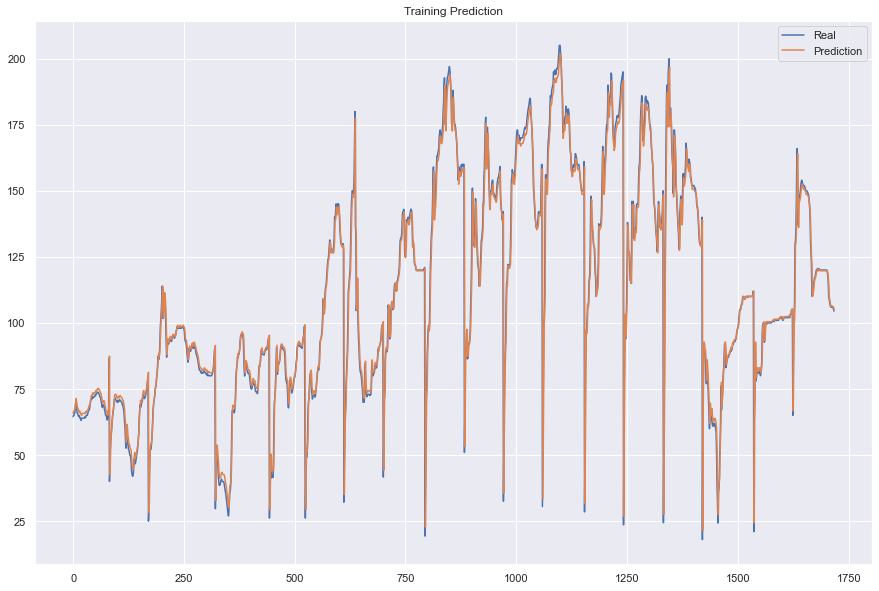

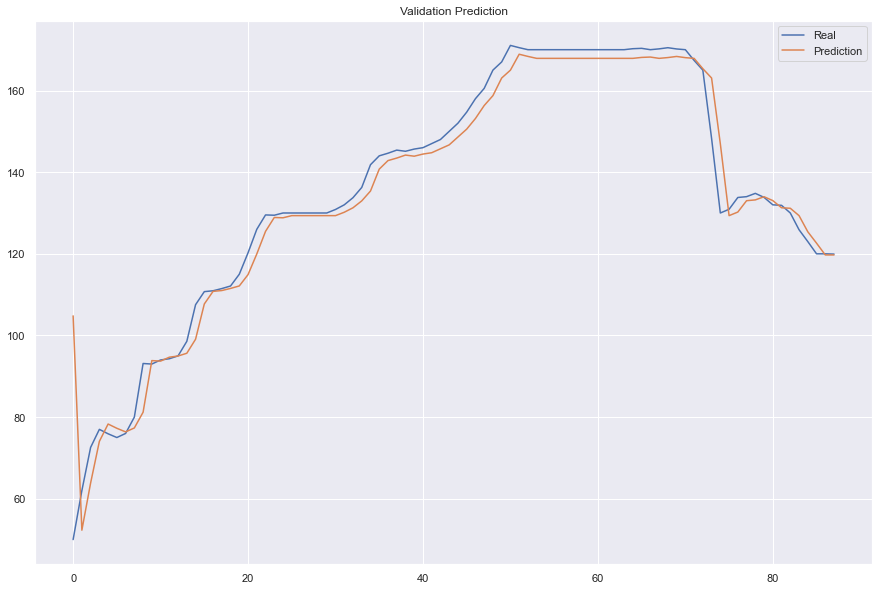

In [26]:

plot_prediction(model2, train2, 'Training Prediction')
plot_prediction(model2, val2, 'Validation Prediction')

Looks good but not since it just mirrors the previous day, we want sth that can do a bit better and actually do some "predicting"

# Linear Reg with lag 1 and 2

In [27]:
df3 = df.copy()
df3['Lag1'] = df3['Value'].shift(1)
df3['Lag2'] = df3['Value'].shift(2)
df3.dropna(inplace=True) # since shifting creates Nan

train3, val3 = train_val_split(df3, ['Value', 'Lag1', 'Lag2'])
print_train_val_stats(train3,val3)


shapes:  (1717, 3) (88, 3)


,Value,Lag1,Lag2
2,65.00280,64.51451,64.00417
3,65.05764,65.00280,64.51451
4,65.98811,65.05764,65.00280
5,66.01724,65.98811,65.05764
6,69.08462,66.01724,65.98811


,Value,Lag1,Lag2
1719,50.00000,104.50518,105.00000
1720,62.00000,50.00000,104.50518
1721,72.57994,62.00000,50.00000
1722,77.00000,72.57994,62.00000
1723,75.91450,77.00000,72.57994


In [28]:
model3 = LinearRegression()
model3.fit(*getXY(train3))

evaluate(model3, *getXY(train3))
evaluate(model3, *getXY(val3))



Result - MSE:  121.74105662562394  - MAPE:  0.04029614607758639
Result - MSE:  51.21533063025776  - MAPE:  0.028685507392833206


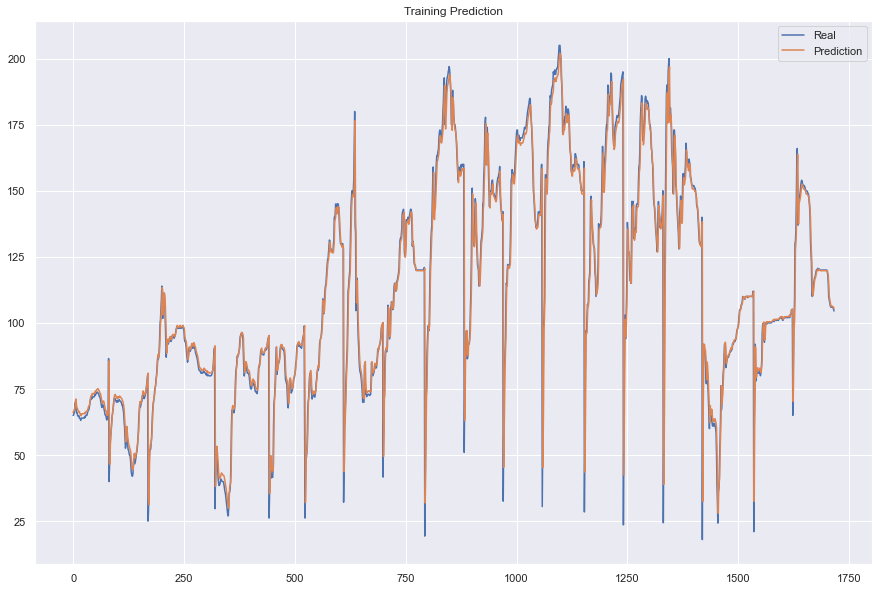

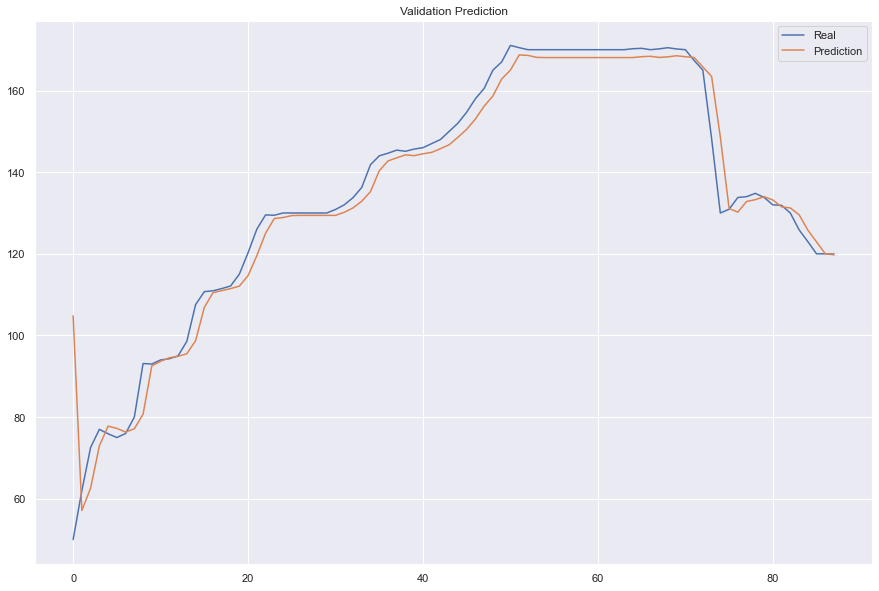

In [29]:
plot_prediction(model3, train3, 'Training Prediction')
plot_prediction(model3, val3, 'Validation Prediction')

basically same